# [CDAF] Atividade 4

## Nome e matrícula
Nome: Luís Felipe Ramos Ferreira
Matrícula: 2019022553

## Referências
- [1] https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- [2] https://socceraction.readthedocs.io/en/latest/api/generated/socceraction.xthreat.ExpectedThreat.html#socceraction.xthreat.ExpectedThreat
- [3] https://socceraction.readthedocs.io/en/latest/api/generated/socceraction.xthreat.get_successful_move_actions.html#socceraction.xthreat.get_successful_move_actions
- [4] https://socceraction.readthedocs.io/en/latest/documentation/valuing_actions/xT.html

In [27]:
# Importando bibliotecas
from tqdm import tqdm
import numpy as np
import pandas as pd
import socceraction.spadl as spd
from socceraction import xthreat as xt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

### LaLiga  p/ SPADL com pré-processamentos

In [2]:
# carregando os eventos
# neste caso, usaremos a mesma base de dados da atv03
path: str = "../data/atv03/events/events_Spain.json"
events: pd.DataFrame = pd.read_json(path_or_buf=path)

In [3]:
# pré processamento em colunas da tabela de eventos para facilitar a conversão p/ SPADL
events = events.rename(columns={'id': 'event_id', 'eventId': 'type_id', 'subEventId': 'subtype_id',
                                'teamId': 'team_id', 'playerId': 'player_id', 'matchId': 'game_id'})
events['milliseconds'] = events['eventSec'] * 1000
events['period_id'] = events['matchPeriod'].replace({'1H': 1, '2H': 2})

In [4]:
# carregando as partidas, pois vamos saber quais times jogam em casa e fora p/ usar como parametro do SPADL
path: str = "../data/atv03/matches/matches_Spain.json"
matches: pd.DataFrame = pd.read_json(path_or_buf=path)

In [5]:
# as informações dos times de cada partida estão em um dicionário dentro da coluna 'teamsData', então vamos separar essas informações
team_matches: list = []
for i in tqdm(range(len(matches))):
    match = pd.DataFrame(matches.loc[i, "teamsData"]).T
    match["matchId"] = matches.loc[i, "wyId"]
    team_matches.append(match)
team_matches = pd.concat(team_matches).reset_index(drop=True)

100%|██████████| 380/380 [00:00<00:00, 1482.89it/s]


In [6]:
# fazendo a conversão p/ SPADL, padronizando a direção de jogo da esquerda p/ a direita e adicionando os nomes dos tipos de ações
spadl: list = []
game_ids: list = events.game_id.unique().tolist()
for g in tqdm(game_ids):
    match_events = events.loc[events.game_id == g]
    match_home_id = team_matches.loc[(team_matches.matchId == g) & (team_matches.side == 'home'), 'teamId'].values[0]
    match_actions = spd.wyscout.convert_to_actions(events=match_events, home_team_id=match_home_id)
    match_actions = spd.play_left_to_right(actions=match_actions, home_team_id=match_home_id)
    match_actions = spd.add_names(match_actions)
    spadl.append(match_actions)
spadl = pd.concat(spadl).reset_index(drop=True)

100%|██████████| 380/380 [02:43<00:00,  2.32it/s]


In [7]:
# adicionando o nome dos jogadores
path: str = "../data/atv03/players/players.json"
players: pd.DataFrame = pd.read_json(path_or_buf=path)
players["player_name"] = players["shortName"]
players = players[["wyId", "player_name"]].rename(columns={"wyId": "player_id"})
spadl = spadl.merge(players, on="player_id", how="left")
spadl.head()

,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,original_event_id,bodypart_id,type_id,result_id,action_id,type_name,result_name,bodypart_name,player_name
0,2565548,1,2.994582,682,3542,38.85,26.52,52.50,34.00,180864419,0,0,1,0,pass,success,foot,Trigueros
1,2565548,1,3.137020,682,274435,52.50,34.00,47.25,47.60,180864418,0,0,1,1,pass,success,foot,E. \u00dcnal
2,2565548,1,6.709668,682,364860,47.25,47.60,39.90,59.84,180864420,0,0,1,2,pass,success,foot,Rodri
3,2565548,1,8.805497,682,3534,39.90,59.84,33.60,21.08,180864421,0,0,1,3,pass,success,foot,Jaume Costa
4,2565548,1,14.047492,682,3695,33.60,21.08,32.55,42.84,180864422,0,0,1,4,pass,success,foot,\u00c1lvaro Gonz\u00e1lez


## Questão 1
- Crei um dataframe "shots" à partir do dataframe "spadl", contendo apenas os chutes.
- Crie 4 colunas no dataframe "shots" a serem usadas como features de um modelo de xG.
- Justifique a escolha das features.

In [8]:
GOAL_CENTER_X: int = 105
GOAL_CENTER_Y: int = 34

UPPER_CROSSBAR_X: int = 105
UPPER_CROSSBAR_Y: int = 38

LOWER_CROSSBAR_X: int = 105
LOWER_CROSSBAR_Y: int = 30

In [9]:
shots: pd.DataFrame = spadl.query('type_name == "shot"').copy()

shots["distance_to_goal"] = np.sqrt((shots["start_x"] - GOAL_CENTER_X) ** 2 - (shots["start_y"] - GOAL_CENTER_Y))

def get_shot_angle(shot_pos_x: np.float_, shot_pos_y: np.float_) -> np.float_:
    v1: np.array = np.array([UPPER_CROSSBAR_X - shot_pos_x, UPPER_CROSSBAR_Y - shot_pos_y])
    v2: np.array = np.array([LOWER_CROSSBAR_X - shot_pos_x, LOWER_CROSSBAR_Y - shot_pos_y])
    return np.arccos(np.dot(v1 / np.linalg.norm(v1), v2 / np.linalg.norm(v2)))
    

shots["angle_of_shot"] = shots[["start_x", "start_y"]].apply(lambda pos: get_shot_angle(pos["start_x"], pos["start_y"]), axis=1)

shots["squared_distance_to_goal"] = shots["distance_to_goal"] ** 2



shots


,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,original_event_id,...,type_id,result_id,action_id,type_name,result_name,bodypart_name,player_name,distance_to_goal,angle_of_shot,squared_distance_to_goal
20,2565548,1,57.771186,695,225089,97.65,44.88,105.00,34.00,180865315,...,11,0,20,shot,fail,foot,Jos\u00e9 Luis Morales,6.568295,0.359618,43.1425
22,2565548,1,60.727239,695,255738,84.00,27.88,84.00,27.88,180864547,...,11,0,22,shot,fail,foot,J. Lerma,21.145212,0.348455,447.1200
93,2565548,1,446.986112,682,37831,92.40,29.24,92.40,29.24,180864486,...,11,0,93,shot,fail,foot,C. Bacca,12.787494,0.547278,163.5200
96,2565548,1,488.929113,682,15214,91.35,23.12,105.00,27.20,180864491,...,11,0,96,shot,fail,foot,A. Rukavina,14.042881,0.361618,197.2025
178,2565548,1,948.872079,695,225089,78.75,40.80,105.00,34.00,180864792,...,11,0,178,shot,fail,foot,Jos\u00e9 Luis Morales,26.120155,0.284055,682.2625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473633,2565927,2,1776.027412,682,267134,97.65,23.12,97.65,23.12,253302272,...,11,0,1226,shot,fail,foot,R. Mart\u00ednez,8.056209,0.359618,64.9025
473673,2565927,2,1944.188119,682,267134,94.50,46.24,94.50,46.24,253302329,...,11,0,1266,shot,fail,foot,R. Mart\u00ednez,9.900000,0.331469,98.0100
473806,2565927,2,2385.837008,682,134174,96.60,51.00,105.00,37.40,253302547,...,11,1,1399,shot,success,foot,Samu Castillejo,7.318470,0.193160,53.5600
473851,2565927,2,2722.835144,675,3321,86.10,47.60,105.00,30.60,253302642,...,11,0,1444,shot,fail,foot,K. Benzema,18.536720,0.279820,343.6100


- Distância até o gol: para essa métrica, considera-se a posição de chute como sendo as posições iniciais das coordenadas x e y do evento de chute, e a posição do gol como sendo as coordenadas (105, 34), exatamente ao centro do gol. A distância entre a bola e o gol no momento do chute é uma das *features* mais óbvias a se pensar quando o assunto 'um modelo de *expected goals*. De maneira simples podemos analisar e notar que chutes de longas distância, de uma forma geral, possuem uma menor probabilidade de resultarem em gol, assim como é análogo o caso de chutes a curta distância.

- Ângulo de chute: para essa métrica, considera-se a posição de chute como sendo as posições iniciais das coordenadas x e y do evento de chute, e a posição das traves do gol como sendo as coordenadas (105, 38) para a trave "de cima" e (105, 30) para a trave "de baixo". Dessa forma, considera-se que o ângulo de chute é o ângulo entre os vetores formados por esses três pontos, onde a  posição da bola seria o ponto de origem. Assim como a distância entre a bola e o gol, o ângulo de chute também é uma das *features* mais óbvias a se pensar ao considerar um modelo de *expected goals*. Chutes que "enxergam" uma grande área do gol comumente possuem maior probabilidade de resultarem em gol, enquanto chutes em posições muito extremas, que significam um baixo ângulo de visão do gol, resultam raramente em sucesso.

- met 3

- met 4

## Questão 2
- Crie uma coluna numérica binária "goal" no dataframe "shots" indicando se o chute resultou em gol ou não.
- Use regressão logística [1] p/ treinar (.fit(X_train, y_train)) um modelo de xG usando as features criadas na questão 1.
- Use 70% dos dados para treino e 30% para teste.
- Reporte a acurácia do modelo para os conjuntos de treino (.score(X_train, y_train)) e teste (.score(X_test, y_test)).

In [24]:
shots["goal"] = shots["result_name"].apply(lambda res: int(res == "success"))
shots.dropna(inplace=True)
X_train, X_test, y_train, y_test = train_test_split(shots[["distance_to_goal", "angle_of_shot", "squared_distance_to_goal"]].to_numpy(), shots["goal"].to_numpy(), test_size=0.3, random_state=0)
clf = LogisticRegression(random_state=0, max_iter=1_000)

clf.fit(X_train, y_train)

print(f"Acurácia para conjunto de treino: {clf.score(X_train, y_train)}")
print(f"Acurácia para conjunto de teste: {clf.score(X_test, y_test)}")

Acurácia para conjunto de treino: 0.893390959841527
Acurácia para conjunto de teste: 0.8987394957983194


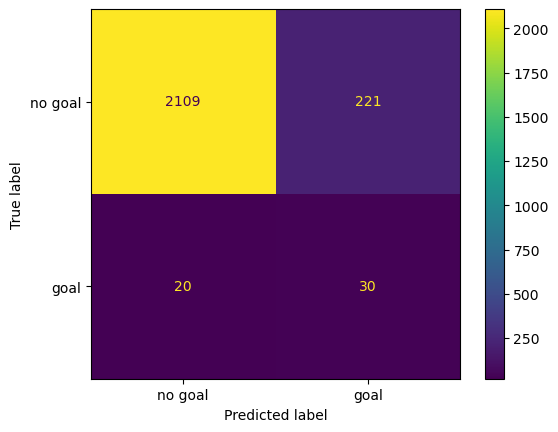

In [30]:
confusion_matrix: np.array = metrics.confusion_matrix(clf.predict(X_test), y_test)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["no goal", "goal"])
cm_display.plot()

discorrer sobre conf matrix

## Questão 3
- Use o modelo treinado na questão 2 p/ prever a probabilidade de gol de todos os chutes do dataframe "shots". Reporte essas probabilidades no dataframe "shots" em uma coluna "xG".
- Agrupe o dataframe "shots" por "player_name" e reporte a soma dos "goal" e "xG".
- Reporte os 10 jogadores com maior xG.
- Reporte os 10 jogadores com maior diferença de Gols e xG.

In [12]:
shots["xG"] = shots[["distance_to_goal", "angle_of_shot", "squared_distance_to_goal"]].apply(lambda x: clf.predict_proba([[x["distance_to_goal"], x["angle_of_shot"], x["squared_distance_to_goal"]]])[0][1], axis=1)
xG_goal_sum: pd.DataFrame = shots.groupby(by="player_name")[["goal", "xG"]].sum().copy()
xG_goal_sum["goal_xG_diff"] = xG_goal_sum["goal"] - xG_goal_sum["xG"]
xG_goal_sum.head()

,goal,xG,goal_xG_diff
player_name,,,
A. Aquilani,0,0.741781,-0.741781
A. Arribas,0,0.107007,-0.107007
A. Fern\u00e1ndez,0,0.026887,-0.026887
A. Griezmann,16,6.942442,9.057558
A. Guardado,0,1.600974,-1.600974


In [13]:
from IPython.display import display_html

largest_xG: pd.DataFrame = xG_goal_sum.nlargest(n=10, columns=["xG"])
largest_goal_xG_diff: pd.DataFrame = xG_goal_sum.nlargest(n=10, columns=["goal_xG_diff"])

largest_xG = largest_xG.style.set_table_attributes("style='display:inline'").set_caption("10 jogadores com maior xG")
largest_goal_xG_diff = largest_goal_xG_diff.style.set_table_attributes("style='display:inline'").set_caption("10 jogadores com maior diferença de Gols e xG")

display_html(largest_xG._repr_html_() + largest_goal_xG_diff._repr_html_(), raw=True)


,goal,xG,goal_xG_diff
player_name,,,
Cristiano Ronaldo,23,22.760589,0.239411
L. Su\u00e1rez,24,17.788362,6.211638
L. Messi,26,15.744470,10.255530
Gerard Moreno,15,15.519503,-0.519503
Maxi G\u00f3mez,18,13.244745,4.755255
C. Stuani,16,13.217736,2.782264
Iago Aspas,19,12.195537,6.804463
Kike Garc\u00eda,7,10.585484,-3.585484
Ra\u00fal Garc\u00eda,7,10.181104,-3.181104


discorrer sobre

## Questão 4 [4]
- Instancie um objeto ExpectedThreat [2] com parâmetros l=25 e w=16.
- Faça o fit do modelo ExpectedThreat com o dataframe "spadl".

In [14]:
xT = xt.ExpectedThreat(l=25, w=16)
xT.fit(actions=spadl)

# iterations:  1


## Questão 5
- Crie um dataframe "prog_actions" à partir do dataframe "spadl", contendo apenas as ações de progressão e que são bem-sucedidas [3].
- Use o método rate do objeto ExpectedThreat p/ calcular o valor de cada ação de progressão do dataframe "prog_actions", em uma coluna chamada "action_value".
- Agrupe o dataframe "prog_actions" por "player_name" e reporte a soma dos "action_value".
- Reporte os 10 jogadores com maior "action_value".

In [15]:
prog_actions: pd.DataFrame = xt.get_successful_move_actions(spadl)

prog_actions["action_value"] = xT.rate(actions=prog_actions)
xT.transition_matrix


NotFittedError: 